In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import io
import os
from PIL import Image

Mount drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My Drive/model

Mounted at /content/drive
/content/drive/My Drive/model



Data split complete.
Total images: 18941
Training images: 12121
Validation images: 3031
Test images: 3789

Sample training images:


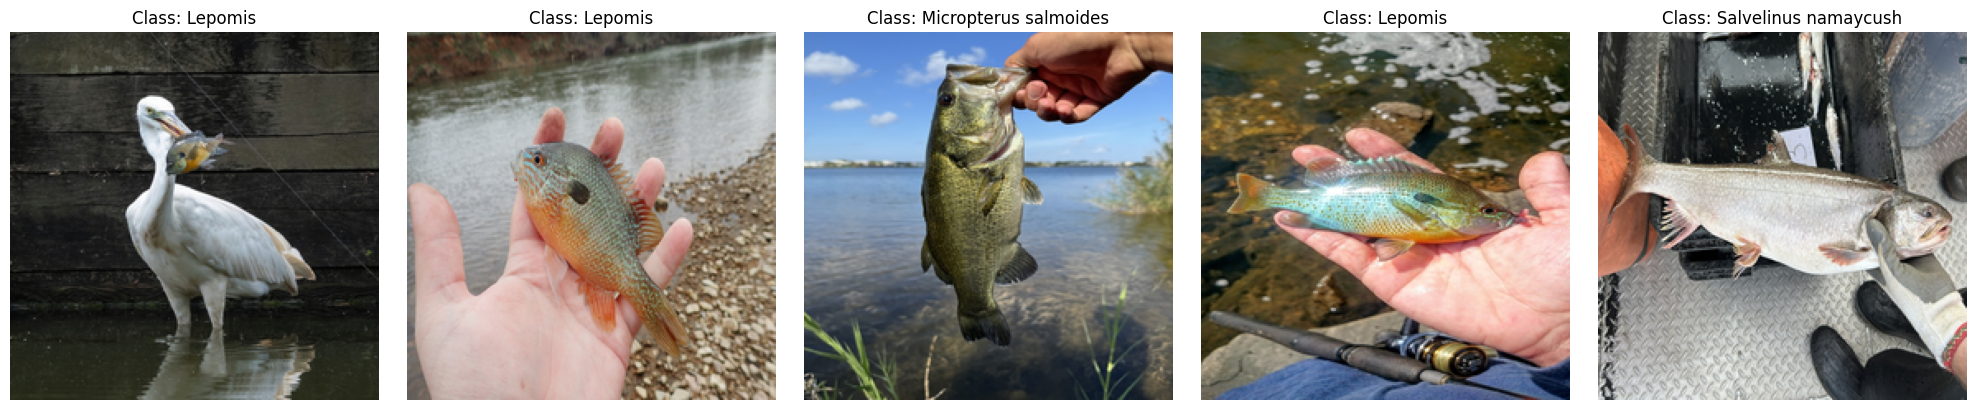

In [3]:
import os
import numpy as np
from PIL import Image
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Base directory containing the dataset
base_dir = 'freshwater_species_images'
# Directory to save the processed data
save_dir = 'freshwater_data_test'

# Create save directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Set the target size for all images
TARGET_SIZE = (224, 224)  # You can adjust this size as needed

# Dictionary to store arrays and labels
data = {
    'images': [],  # This will be a list of NumPy arrays
    'labels': [],
    'label_map': {}  # To map folder names to numeric labels
}

label_counter = 0

for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)

    # Skip if not a directory
    if not os.path.isdir(folder_path):
        continue

    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)

        # Assign a numeric label to this folder
        if folder not in data['label_map']:
            data['label_map'][folder] = label_counter
            label_counter += 1

        if not os.path.isdir(subfolder_path):
            continue

        for f in os.listdir(subfolder_path):
            if f.endswith('.jpg'):
                file_path = os.path.join(subfolder_path, f)

                # Open the image, resize it, convert to RGB, and convert to numpy array
                try:
                    with Image.open(file_path) as img:
                        img_resized = img.resize(TARGET_SIZE, Image.LANCZOS)
                        img_rgb = img_resized.convert('RGB')  # Ensure image is in RGB format
                        img_array = np.array(img_rgb)

                        # Check if the image has the correct shape
                        if img_array.shape == (TARGET_SIZE[0], TARGET_SIZE[1], 3):
                            # Add the image array and its label to our data
                            data['images'].append(img_array)
                            data['labels'].append(data['label_map'][folder])
                except Exception as e:
                    print(f"Error processing {file_path}: {str(e)}")

# Convert images and labels to numpy arrays
data['images'] = np.array(data['images'])
data['labels'] = np.array(data['labels'])

# Shuffle the data
shuffled_images, shuffled_labels = shuffle(data['images'], data['labels'], random_state=42)

# First, split into train+validation and test sets (80% train+validation, 20% test)
train_val_images, test_images, train_val_labels, test_labels = train_test_split(
    shuffled_images, shuffled_labels, test_size=0.2, random_state=42)

# Then, split train+validation into train and validation sets (80% train, 20% validation)
train_images, val_images, train_labels, val_labels = train_test_split(
    train_val_images, train_val_labels, test_size=0.2, random_state=42)

print("\nData split complete.")
print(f"Total images: {len(shuffled_images)}")
print(f"Training images: {len(train_images)}")
print(f"Validation images: {len(val_images)}")
print(f"Test images: {len(test_images)}")

# Save the data
np.save(os.path.join(save_dir, 'train_images.npy'), train_images)
np.save(os.path.join(save_dir, 'train_labels.npy'), train_labels)
np.save(os.path.join(save_dir, 'val_images.npy'), val_images)
np.save(os.path.join(save_dir, 'val_labels.npy'), val_labels)
np.save(os.path.join(save_dir, 'test_images.npy'), test_images)
np.save(os.path.join(save_dir, 'test_labels.npy'), test_labels)

# Save the label map
np.save(os.path.join(save_dir, 'label_map.npy'), data['label_map'])

# Create a reverse label map for displaying class names
reverse_label_map = {v: k for k, v in data['label_map'].items()}

# Function to plot images
def plot_images(images, labels, num_images=5):
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i])
        plt.title(f"Class: {reverse_label_map[labels[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("\nSample training images:")
plot_images(train_images, train_labels)

In [ ]:
train_images = np.load('freshwater_data/train_images.npy')
train_labels = np.load('freshwater_data/train_labels.npy')
test_images = np.load('freshwater_data/test_images.npy')
test_labels = np.load('freshwater_data/test_labels.npy')
val_images = np.load('freshwater_data/val_images.npy')
val_labels = np.load('freshwater_data/val_labels.npy')

In [6]:
print(train_labels[:10])

[ 9  9  0  9 11  9  8 10 13  3]


In [7]:
from tensorflow.keras.utils import to_categorical

# Assuming y_train is your target data
train_labels = to_categorical(train_labels, num_classes=14)
val_labels = to_categorical(val_labels, num_classes=14)
test_labels = to_categorical(test_labels, num_classes=14)

In [ ]:
print(train_images.shape)

(2417, 224, 224, 3)


In [ ]:
print(test_images.shape)

(756, 224, 224, 3)


In [20]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV3Large

# Create the base model from MobileNetV2
base_model = MobileNetV3Large(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base model
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(14, activation='softmax')  # Assuming 13 classes
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 global_average_pooling2d_3  (None, 960)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 128)               123008    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 14)                1806      
                                                                 
Total params: 3121166 (11.91 MB)
Trainable params: 124

In [21]:
# Implement early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [22]:
history = model.fit(
    train_images, train_labels,
    epochs=100,
    batch_size=256,
    validation_data=(val_images, val_labels),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
48/48 [==============================] - 18s 273ms/step - loss: 2.1460 - accuracy: 0.3492 - val_loss: 1.6349 - val_accuracy: 0.4939
Epoch 2/100
48/48 [==============================] - 11s 225ms/step - loss: 1.6048 - accuracy: 0.4901 - val_loss: 1.3990 - val_accuracy: 0.5757
Epoch 3/100
48/48 [==============================] - 11s 227ms/step - loss: 1.4109 - accuracy: 0.5436 - val_loss: 1.2738 - val_accuracy: 0.6011
Epoch 4/100
48/48 [==============================] - 11s 225ms/step - loss: 1.2840 - accuracy: 0.5785 - val_loss: 1.2173 - val_accuracy: 0.6133
Epoch 5/100
48/48 [==============================] - 11s 225ms/step - loss: 1.1880 - accuracy: 0.6094 - val_loss: 1.1656 - val_accuracy: 0.6245
Epoch 6/100
48/48 [==============================] - 11s 224ms/step - loss: 1.1140 - accuracy: 0.6293 - val_loss: 1.1287 - val_accuracy: 0.6381
Epoch 7/100
48/48 [==============================] - 11s 224ms/step - loss: 1.0629 - accuracy: 0.6447 - val_loss: 1.1023 - val_accuracy:

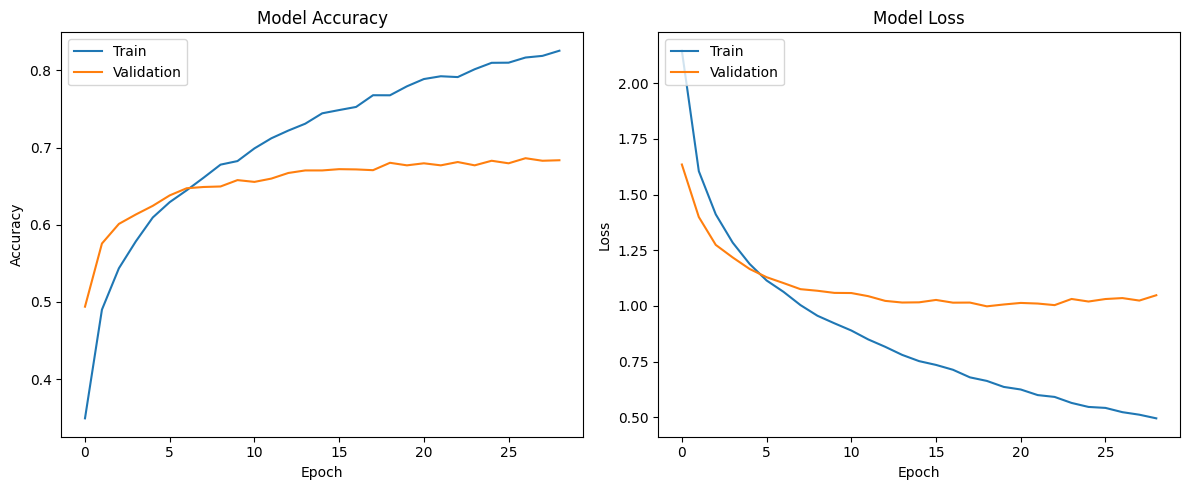

In [23]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Summarize history for accuracy
    plt.figure(figsize=(12,5))
    plt.subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Summarize history for loss
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Assuming 'history' is the returned history object from model.fit()
plot_training_history(history)

In [25]:
model.save('model_v1')